<a href="https://colab.research.google.com/github/Velociraptorvelraptor/agricultural_crops_img_classification/blob/main/Agricultural_crops_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.5 MB/s eta 0:00:00


In [2]:
!mkdir /root/.kaggle

In [3]:
!mv /content/kaggle.json /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mdwaquarazam/agricultural-crops-image-classification

 89% 70.0M/79.0M [00:00<00:00, 104MB/s]
100% 79.0M/79.0M [00:00<00:00, 117MB/s]


In [ ]:
!unzip /content/agricultural-crops-image-classification.zip

In [7]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torchmetrics import Accuracy, Precision, F1Score

In [40]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

In [41]:
datafolder = ImageFolder('/content/Agricultural-crops', transforms)

In [42]:
len(datafolder.classes)

30

In [43]:
labels = [label for img, label in datafolder]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


(array([92., 81., 93., 76., 87., 78., 82., 84., 72., 84.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <a list of 10 Patch objects>)

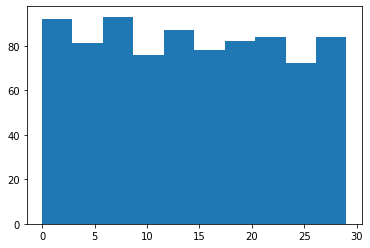

In [44]:
plt.hist(labels)

In [45]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

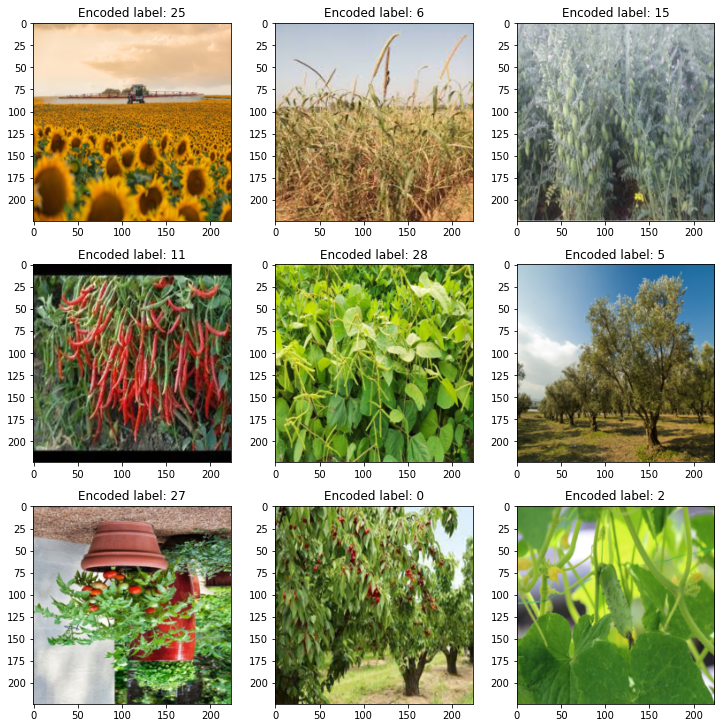

In [46]:
fig, axs = plt.subplots(3, 3, figsize=[10, 10], constrained_layout=True)
for i, ax in enumerate(axs.flat):
  k = random.randint(0, len(datafolder))
  img, label = datafolder.__getitem__(k) 
  ax.set_title(f'Encoded label: {label}')
  ax.imshow(img_display(img))
     

In [56]:
train_len = int(np.floor(len(datafolder) * 0.8))
val_len = int(len(datafolder) - train_len)

In [57]:
train_ds, val_ds = random_split(datafolder, [train_len, val_len])

In [58]:
train_dl = DataLoader(train_ds, 64, shuffle=False)
val_dl = DataLoader(val_ds, 64, shuffle=False)

In [59]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

In [60]:
#Benchmark model

class BenchmarkCNN(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2)
    self.drop = nn.Dropout(0.2)
    self.fc = nn.Linear(28 * 28 * 64, n_classes)

  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = self.batchnorm1(x)
    x = F.relu(self.pool(self.conv3(x)))
    x = self.batchnorm2(x)
    x = F.dropout(self.drop(x), training=self.training)
    x = x.view(-1, 28 * 28 * 64)
    x = self.fc(x)
    return torch.log_softmax(x, dim=1)

In [61]:
# Create an instance of the model class and allocate it to the device
model = BenchmarkCNN(n_classes=len(datafolder.classes)).to(device)

print(model)

BenchmarkCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50176, out_features=30, bias=True)
)


In [62]:
def train(model, device, train_loader, loss_fn, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    print("\nEpoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_fn(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()
        acc = 100. * correct / len(train_loader.dataset)
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        #print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print(f'Train loss: {avg_loss:.5f}, acc: {acc:.2f}.')
    return avg_loss, acc

In [63]:
def test(model, device, test_loader, loss_fn):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    cm = {}
    cm['predictions'] = []
    cm['targets'] = []

    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_fn(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            cm['predictions'].append(predicted)
            cm['targets'].append(target)

    acc = 100. * correct / len(test_loader.dataset)
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print(f'Test loss: {avg_loss:.5f}, acc: {acc:.2f}.')
    
    # return average loss for the epoch
    return avg_loss, acc, cm

In [64]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_fn = nn.CrossEntropyLoss().to(device)

# Track metrics in these arrays
epoch_nums = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

epochs = 20
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_dl, loss_fn, optimizer, epoch)
    test_loss, test_acc, _ = test(model, device, val_dl, loss_fn)
    epoch_nums.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Training on cuda

Epoch: 1
Train loss: 55.50799, acc: 6.64.
Test loss: 176.81279, acc: 2.41.

Epoch: 2
Train loss: 61.77190, acc: 13.57.
Test loss: 140.06812, acc: 7.23.

Epoch: 3
Train loss: 57.76766, acc: 18.70.
Test loss: 77.52100, acc: 5.42.

Epoch: 4
Train loss: 38.93827, acc: 23.38.
Test loss: 42.24146, acc: 14.46.

Epoch: 5
Train loss: 28.26978, acc: 34.99.
Test loss: 43.54303, acc: 15.66.

Epoch: 6
Train loss: 22.97750, acc: 33.63.
Test loss: 40.07859, acc: 15.06.

Epoch: 7
Train loss: 21.00293, acc: 41.33.
Test loss: 31.08389, acc: 18.67.

Epoch: 8
Train loss: 13.92832, acc: 51.13.
Test loss: 36.92715, acc: 15.06.

Epoch: 9
Train loss: 10.84768, acc: 52.49.
Test loss: 25.37694, acc: 22.89.

Epoch: 10
Train loss: 8.14123, acc: 59.88.
Test loss: 24.25027, acc: 21.08.

Epoch: 11
Train loss: 7.37732, acc: 60.78.
Test loss: 23.88730, acc: 24.10.

Epoch: 12
Train loss: 5.14325, acc: 66.97.
Test loss: 19.35644, acc: 25.30.

Epoch: 13
Train loss: 3.92517, acc: 70.89.
Test loss: 16.621

In [65]:
metrics = pd.DataFrame({'epoch': epoch_nums,
                        'train_loss': train_losses,
                        'train_accuracy': train_accs,
                        'test_loss': test_losses,
                        'test_accuracy': test_accs})

In [66]:
metrics.head(5)

,epoch,train_loss,train_accuracy,test_loss,test_accuracy
0,1,55.507991,6.636501,176.812790,2.409639
1,2,61.771896,13.574661,140.068115,7.228916
2,3,57.767655,18.702866,77.520999,5.421687
3,4,38.938266,23.378582,42.241459,14.457831
4,5,28.269777,34.992459,43.543030,15.662651


In [67]:
def visualize(n, metric):
  axs[n].plot(metrics['epoch'], metrics[f'train_{metric}'], label=f'Training {metric}', ls='--')
  axs[n].plot(metrics['epoch'], metrics[f'test_{metric}'], label=f'Validation {metric}', ls='dotted')

  axs[n].set_title(f'Training and Validation {metric}')
  axs[n].set_xlabel('Epochs')
  axs[n].set_ylabel(metric)
  axs[n].legend()


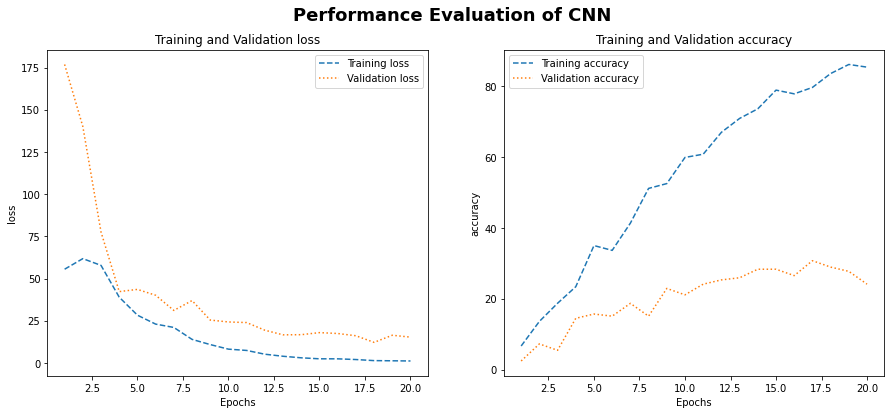

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
visualize(0, 'loss')
visualize(1, 'accuracy')
plt.suptitle(f"Performance Evaluation of CNN", fontsize=18, fontweight='bold')
plt.show()

In [69]:
predictions = []
true_labels = []

val_dl = DataLoader(val_ds, 166, shuffle=False)
test_loss, test_acc, cm = test(model, device, val_dl, loss_fn)

Test loss: 15.98907, acc: 28.31.


In [70]:
cm = confusion_matrix(cm['predictions'][0].cpu().numpy(), cm['targets'][0].cpu().numpy())

In [71]:
df_cm = pd.DataFrame(cm)

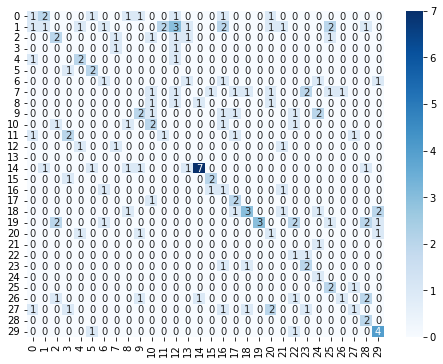

In [72]:
plt.figure(figsize=[8, 6])
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')

Transfer learning - efficientnet

In [73]:
import torchvision.models.efficientnet as e

In [79]:
class TransferLearningCNN(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.model = e.efficientnet_b0(pretrained=True)
    for param in self.model.parameters():
      param.require_grad = False
  
    self.model.fc = nn.Sequential(
      nn.Linear(1024, 512),
      nn.Dropout(0.2),      
      nn.Linear(1024, 30)
      )
    self.model.to(device)

  def forward(self, x):
    return self.model(x)

In [80]:
model = TransferLearningCNN(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_fn = nn.CrossEntropyLoss().to(device)

# Track metrics in these arrays
epoch_nums = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_dl, loss_fn, optimizer, epoch)
    test_loss, test_acc, _ = test(model, device, val_dl, loss_fn)
    epoch_nums.append(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Training on cuda

Epoch: 1


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


Train loss: 4.81342, acc: 22.02.
Test loss: 2.71969, acc: 33.73.

Epoch: 2
Train loss: 0.79115, acc: 82.81.
Test loss: 1.27806, acc: 66.87.

Epoch: 3
Train loss: 0.25034, acc: 92.76.
Test loss: 1.10922, acc: 73.49.

Epoch: 4
Train loss: 0.10543, acc: 97.59.
Test loss: 0.98023, acc: 74.70.

Epoch: 5
Train loss: 0.04521, acc: 99.10.
Test loss: 0.99871, acc: 72.29.

Epoch: 6
Train loss: 0.02290, acc: 99.55.
Test loss: 0.99385, acc: 72.89.

Epoch: 7
Train loss: 0.01866, acc: 99.55.
Test loss: 0.93747, acc: 76.51.

Epoch: 8
Train loss: 0.01694, acc: 99.25.
Test loss: 0.91334, acc: 78.31.

Epoch: 9
Train loss: 0.01284, acc: 99.55.
Test loss: 0.99408, acc: 74.10.

Epoch: 10
Train loss: 0.01316, acc: 99.70.
Test loss: 1.11418, acc: 73.49.


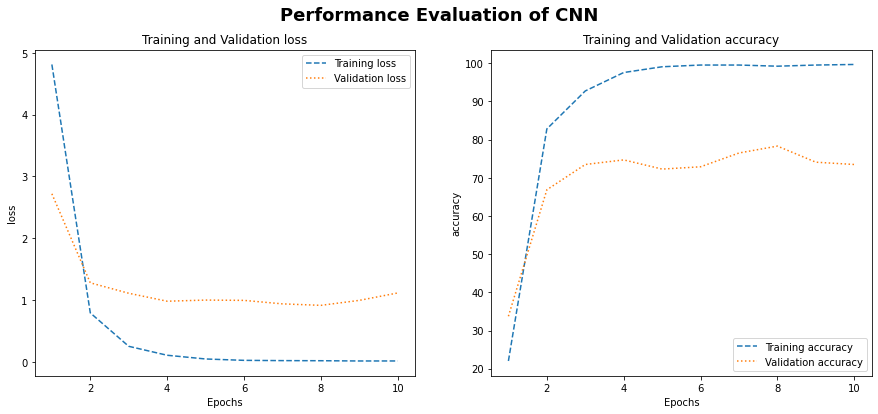

In [82]:
metrics = pd.DataFrame({'epoch': epoch_nums,
                        'train_loss': train_losses,
                        'train_accuracy': train_accs,
                        'test_loss': test_losses,
                        'test_accuracy': test_accs})

def visualize(n, metric):
  axs[n].plot(metrics['epoch'], metrics[f'train_{metric}'], label=f'Training {metric}', ls='--')
  axs[n].plot(metrics['epoch'], metrics[f'test_{metric}'], label=f'Validation {metric}', ls='dotted')

  axs[n].set_title(f'Training and Validation {metric}')
  axs[n].set_xlabel('Epochs')
  axs[n].set_ylabel(metric)
  axs[n].legend()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
visualize(0, 'loss')
visualize(1, 'accuracy')
plt.suptitle(f"Performance Evaluation of CNN", fontsize=18, fontweight='bold')
plt.show()

Highest accuracy on the test set: efficientnet acc: 78.31.